![user-user](./wallpaper.jpg)

# Memory Based Collaborative Filtering

- https://www.springer.com/gp/book/9783319296579
- https://numpy.org/

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes

In [2]:
np.random.seed(10)

## Cold Start

Removing users with a low amount of ratings.

In [3]:
def get_hot_users(ratings: np.array, min_ratings: int = 10) -> np.array:
    """
    Cold Start users removal.
    """
    return ratings[np.sum(~np.isnan(ratings), axis=1) >= min_ratings]

In [4]:
X: np.array = np.array([
    [1, 1, 1, 2, 3],
    [1, 1, np.nan, 2, 3],
    [np.nan, np.nan, 3, np.nan, 2],
])
Y: np.array = get_hot_users(X, 3)
print(Y)

[[ 1.  1.  1.  2.  3.]
 [ 1.  1. nan  2.  3.]]


## User-Rating Matrix

The ratings matrix is denoted by `R` and it is an `m` by `n` matrix containing `m` users and `n` items. The rating of user `u1` for item `i3` is denoted by `r13`.

$$ U = \{ u_1, u_2 ... u_m \} \land |U| = m $$

$$ I = \{ i_1, i_2 ... i_n \} \land |I| = n $$

$$ R = \{ r_{1,1}, r_{1,2} ... r_{2,1}, r_{2,2} ... r_{m,n} \} \land |R| = m \times n $$

In [5]:
def get_random_ratings_matrix(users: int = 10, items: int = 15, min_rating: float = 0, max_rating: float = 5) -> np.array:
    """
    Random dataset generator.
    """
    ratings: np.array = max_rating * np.random.randn(users, items)
    ratings[ratings < min_rating] = np.nan
    ratings[ratings > max_rating] = max_rating
    ratings = np.floor(ratings)
    return ratings

In [6]:
ratings: np.array = get_hot_users(get_random_ratings_matrix(users=10, items=15), 2)
print(ratings)

[[ 5.  3. nan nan  3. nan  1.  0.  0. nan  2.  5. nan  5.  1.]
 [ 2. nan  0.  5. nan nan nan  1.  5.  5.  5.  0.  5. nan  3.]
 [nan nan  0. nan  5.  0.  2. nan  5. nan  3. nan nan nan nan]
 [nan nan  1.  2. nan nan  1. nan  3.  4.  1.  5.  4. nan nan]
 [nan nan  5. nan nan nan  5. nan nan nan  1.  2. nan  4.  1.]
 [ 5. nan  3. nan nan  5.  5. nan nan nan nan nan  1.  1. nan]
 [ 5.  1. nan nan  3.  4. nan  0.  4. nan  0. nan nan  2. nan]
 [nan nan  4.  3. nan  1. nan  5. nan nan nan nan  0.  1. nan]
 [nan nan  5.  5.  5.  1.  5.  0.  5.  3. nan nan nan  1. nan]
 [nan  5.  0.  5.  5. nan nan nan nan  1.  5. nan nan  1.  5.]]


## Views Matrix

In [7]:
def get_random_views_matrix(ratings: np.array) -> np.array:
    """
    Random views matrix generator.
    """
    return np.floor(np.random.lognormal(0, 1, ratings.size)).reshape(ratings.shape)

In [8]:
views: np.array = get_random_views_matrix(ratings)
print(views)

[[ 1.  1.  3.  1.  0.  1.  0.  1.  2.  0.  3.  0.  1.  1.  0.]
 [ 0.  0.  0.  1.  0.  0.  1.  3.  1.  0.  0.  1.  1.  2.  0.]
 [ 0.  0.  1.  2.  9.  1.  1.  0.  0.  2.  1.  0.  0.  0.  0.]
 [ 3.  2.  0.  3.  0.  1.  3.  0.  1.  0.  0.  2.  1.  0.  0.]
 [ 0.  3.  1.  0.  0.  1.  0.  3.  1.  3.  0.  2.  1.  0.  1.]
 [ 1.  0.  0.  1.  0.  0.  1.  1.  1.  1.  1.  0.  0.  0.  3.]
 [ 0.  1.  0.  0.  0.  0.  2.  0.  5.  3.  0.  0.  0.  1.  1.]
 [ 4.  0.  1.  0.  0.  6.  1.  1.  0.  0.  1.  0.  1.  1.  0.]
 [ 1.  1.  0.  0.  0.  1.  2.  0.  3.  1.  0.  1.  2.  1. 10.]
 [ 1.  2.  1.  2.  0.  0.  0.  1.  1.  2.  1.  1.  0.  1.  2.]]


## Normalization

- https://en.wikipedia.org/wiki/Normalization_(statistics)

In statistics and applications of statistics, normalization can have a range of meanings. In the simplest cases, normalization of ratings means adjusting values measured on different scales to a notionally common scale, often prior to averaging.

$$ \bar{\mu} = \frac{\sum\limits^{^n}_{i=1} x_i}{n}	 $$

$$ σ^2 = \frac{\sum\limits^{^n}_{i=1} (x_i - \bar{\mu})^2}{n}	 $$

$$ z = \frac{x_i - \bar{\mu}}{σ}	 $$

In [9]:
def get_normalized_matrix(matrix: np.array) -> tuple:
    """
    Normalization Function.
    Returns z-score of each element in the input matrix.
    """    
    sample_size: np.array = np.sum(~np.isnan(matrix), axis=1)
    sample_size[sample_size == 0] = 1    
    mean: np.array = np.nansum(matrix, axis=1) / sample_size
    mean = mean.reshape(mean.shape[0], 1)
    variance: np.array = np.nansum(np.power(matrix - mean, 2), axis=1) / sample_size
    variance = variance.reshape(variance.shape[0], 1)
    variance[variance == 0] = 1
    deviation: np.array = np.sqrt(variance)
    normalized: np.array = (matrix - deviation) / deviation
    return mean, deviation, normalized

ORIGINAL [[ 0.75529996  1.9905968   1.98226592  2.63827669  3.97304436  5.90503196
   8.27812396  8.01711704  9.37389152  8.34139529]
 [22.67991031 25.56314454 35.15111594 39.44395266 47.62437791 54.14855401
  60.0643194  66.5002613  72.39262356 79.9464055 ]]
NORMALIZED [[-0.75314832 -0.34942116 -0.35214391 -0.13774252  0.29849429  0.92991812
   1.70550634  1.62020249  2.06363169  1.72618506]
 [ 0.21772293  0.37252867  0.88732315  1.11781285  1.55703378  1.90732789
   2.22495538  2.57051204  2.88688298  3.29245837]]


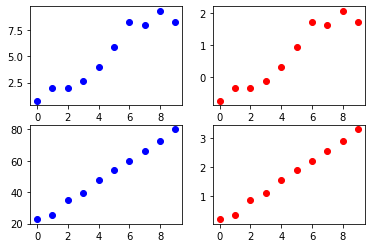

In [10]:
x: np.array = np.vstack([
    np.linspace(0, 10, 10) + np.random.normal(0, 1, 10),
    20 + np.linspace(0, 60, 10) + np.random.normal(0, 1, 10),
])
mean, deviation, y = get_normalized_matrix(x)
assert x.shape == y.shape
print('ORIGINAL', x)
print('NORMALIZED', y)
grid = np.arange(x.shape[1])
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot(2, 2, 1)
axes.plot(grid, x[0].flat, 'o', color='blue')
axes: Axes = figure.add_subplot(2, 2, 2)
axes.plot(grid, y[0].flat, 'o', color='red')
axes: Axes = figure.add_subplot(2, 2, 3)
axes.plot(grid, x[1].flat, 'o', color='blue')
axes: Axes = figure.add_subplot(2, 2, 4)
axes.plot(grid, y[1].flat, 'o', color='red')
plt.show()

## Entropy

- https://en.wikipedia.org/wiki/Entropy_(information_theory)

In information theory, the entropy of a random variable is the average level of "information", "surprise", or "uncertainty" inherent in the variable's possible outcomes.

$$ H(x) = - \sum\limits^{^n}_{i=1} P(x_i) \cdot log P(x_i) $$

In [11]:
def get_entropy_array(matrix: np.array) -> np.array:
    """
    Entropy Matrix.
    """
    P: np.matrix = np.count_nonzero(~np.isnan(matrix.T), axis=1) / matrix.shape[0]
    P[P == 0] = 1
    return np.abs(np.log(P))

In [12]:
X: np.array = np.array([
    [1, np.nan, 3, np.nan, np.nan],
    [4, 5, np.nan, np.nan, np.nan],
    [7, 8, 9, 5, np.nan],
    [7, 8, 9, np.nan, np.nan],
    [7, 8, 9, np.nan, np.nan],
    [7, 8, 9, np.nan, np.nan],
    [7, 8, 9, np.nan, np.nan],
    [1, 2, 2, np.nan, np.nan]
])
E: np.array = get_entropy_array(X)
print(X)
print(E)

[[ 1. nan  3. nan nan]
 [ 4.  5. nan nan nan]
 [ 7.  8.  9.  5. nan]
 [ 7.  8.  9. nan nan]
 [ 7.  8.  9. nan nan]
 [ 7.  8.  9. nan nan]
 [ 7.  8.  9. nan nan]
 [ 1.  2.  2. nan nan]]
[0.         0.13353139 0.13353139 2.07944154 0.        ]


## Cosine Similarity

- https://en.wikipedia.org/wiki/Cosine_similarity

Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space. It is defined to equal the cosine of the angle between them, which is also the same as the inner product of the same vectors normalized to both have length 1.

$$ cos(X, Y) = \frac{X \cdot Y}{ \left \Vert X \right \| \cdot \left \Vert Y \right \| } = \frac{ \sum\limits^{^n}_{i=1} X_i \cdot Y_i }{ \sqrt{\sum\limits^{^n}_{i=1} X_i^2} \cdot \sqrt{\sum\limits^{^n}_{i=1} Y_i^2} } $$

In [13]:
def get_cosine(X: np.array, Y: np.array, min_shared_ratings: int = 3) -> float:
    """
    Cosine Similarity function.
    """
    union: np.array = ~np.isnan(np.sum([X, Y], axis=0))
    if np.count_nonzero(union) == 0:
        return 0
    discount: float = min(min_shared_ratings, np.count_nonzero(union)) / min_shared_ratings
    return discount * np.sum(X[union] * Y[union]) / \
        (max(0.0000001, np.sqrt(np.sum(np.power(X[union], 2)))) *\
         max(0.0000001, np.sqrt(np.sum(np.power(Y[union], 2)))))

[ 1. nan  2.  3.  4.  5.  6.  7.  8.  9.] [ 1.  3.  2.  2. nan  8.  9. 10. 11. 12.] 0.9929196160911488


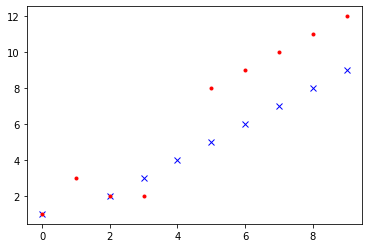

In [14]:
X: np.array = np.array([1, np.nan, 2, 3, 4, 5, 6, 7, 8, 9])
Y: np.array = np.array([1, 3, 2, 2, np.nan, 8, 9, 10, 11, 12])
print(X, Y, get_cosine(X, Y))
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot()
axes.plot(np.arange(X.shape[0]), X, 'x', color='blue')
axes.plot(np.arange(Y.shape[0]), Y, '.', color='red')
plt.show()

[ 1. nan  2.  3.  4.  5.  6.  7.  8.  9.] [ 10.  30.  20.  20.  nan  80.  90. 100. 110. 120.] 0.9929196160911488


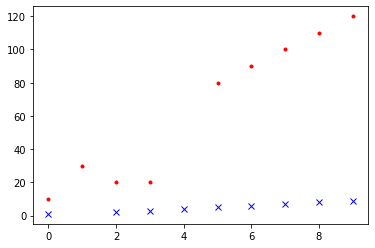

In [15]:
X: np.array = np.array([1, np.nan, 2, 3, 4, 5, 6, 7, 8, 9])
Y: np.array = np.array([10, 30, 20, 20, np.nan, 80, 90, 100, 110, 120])
print(X, Y, get_cosine(X, Y))
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot()
axes.plot(np.arange(X.shape[0]), X, 'x', color='blue')
axes.plot(np.arange(Y.shape[0]), Y, '.', color='red')
plt.show()

[ 1. nan  2.  3.  4.  5.  7.  9. 10.] [100.  65.  32.  24.  nan  10.   7.   4.   2.] 0.21975098781417202


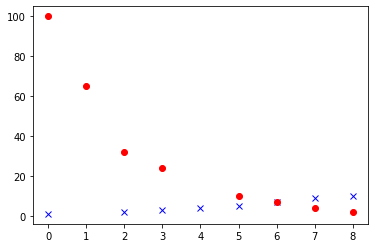

In [16]:
X: np.array = np.array([1, np.nan, 2, 3, 4, 5, 7, 9, 10])
Y: np.array = np.array([100, 65, 32, 24, np.nan, 10, 7, 4, 2])
print(X, Y, get_cosine(X, Y))
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot()
axes.plot(np.arange(X.shape[0]), X, 'x', color='blue')
axes.plot(np.arange(Y.shape[0]), Y, 'o', color='red')
plt.show()

## Similarity Matrix

In [17]:
def get_similarity_matrix(matrix: np.array, min_shared_ratings: int = 3) -> np.array:
    """
    Get similarity matrix out of a given matrix.
    """
    correlations: np.array = np.stack([
        [
            0 if i >= j else get_cosine(x, y, min_shared_ratings=min_shared_ratings)
            for j, y in enumerate(matrix)
        ]
        for i, x in enumerate(matrix)
    ])
    return correlations + correlations.T

In [18]:
X: np.array = np.array([ [1, 2, 3], [4, 5, 6], [7, 8, 9] ])
S: np.array = get_similarity_matrix(X)
print(X)
print(S)

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[0.         0.97463185 0.95941195]
 [0.97463185 0.         0.99819089]
 [0.95941195 0.99819089 0.        ]]


## Top K-Similar Rows

- https://en.wikipedia.org/wiki/Adjacency_matrix
- https://numpy.org/doc/stable/reference/generated/numpy.argsort.html

In graph theory and computer science, an adjacency matrix is a square matrix used to represent a finite graph. The elements of the matrix indicate whether pairs of vertices are adjacent or not in the graph.

In [19]:
def get_adjacency_matrix(similar: np.array, top: int = 4) -> np.array:
    """
    Get top k similar rows of a similarity matrix.
    """
    closest: np.array = np.argsort(similar)
    return closest[:, closest.shape[1] - top:]

In [20]:
X: np.array = np.array([
    [0, 2, 3, 1],
    [8, 0, 6, 1],
    [7, 6, 0, 2],
    [2, 3, 1, 0]
])
S: np.array = get_adjacency_matrix(X, 2)
print(X)
print(S)

[[0 2 3 1]
 [8 0 6 1]
 [7 6 0 2]
 [2 3 1 0]]
[[1 2]
 [2 0]
 [1 0]
 [0 1]]


## Collaborative Filtering

Filling the collaborative filtering matrix with ratings from similar rows. The predicted value is the weighted sum of the adjacent rows. Values are denormalized so that the approximate user scores. Entropy is applied to promote novelty across recommendations.

$$ \hat{R_{i,j}} = \mu + σ \cdot \frac{ \sum\limits^{^n}_{u=1} w_u \cdot R_{u,j} }{ \sum\limits^{^n}_{u=1} w_u } $$

$$ E = \{ (r_{1,1} - \hat{r_{1,1}}), (r_{1,2} - \hat{r_{1,2}}), ..., (r_{i,j} - \hat{r_{i,j}}) \} $$

In [21]:
def get_predictions_matrix(ratings: np.array, normalized: np.array, mean: np.array, deviation: np.array, entropy: np.array, adjacent: np.array, similarity: np.array) -> np.array:
    """
    Collaborative Filtering function.
    """
    predictions: np.array = np.empty(ratings.shape)
    for i in range(normalized.shape[0]):
        for j in range(normalized.shape[1]):
            predictions[i, j] = np.nan
            total: float = 0
            weights: float = 0
            y: float = ratings[i][j]
            for k in adjacent[i]:
                if np.isnan(normalized[k][j]):
                    continue
                weight: float = similarity[i][k] * entropy[k]
                weights += weight
                total += normalized[k][j] * weight
            if weights > 0:
                y: float = mean[i].flat[0] + deviation[i].flat[0] * total / weights
            predictions[i, j] = y
    return predictions

In [22]:
def get_recommendations_matrix(ratings: np.array, predictions: np.array) -> np.array:
    """
    Collaborative Filtering function.
    """
    r = np.isnan(ratings).reshape(ratings.size)
    t = predictions.reshape(predictions.size)
    t[r] = np.nan
    return t.reshape(predictions.shape)

In [23]:
X: np.array = np.array([
    [1., np. nan],
    [np.nan, 1.],
])
Y: np.array = np.array([
    [2., 0.],
    [0., 2.]
])
Z: np.array = get_recommendations_matrix(X ,Y)
print(Z)

[[ 2. nan]
 [nan  2.]]


## Evaluation

$$ E = \{ (r_{1,1} - \hat{r_{1,1}}), (r_{1,2} - \hat{r_{1,2}}), ..., (r_{i,j} - \hat{r_{i,j}}) \} $$

$$ RMSE = \sqrt{ \frac{ \sum\limits^{^n}_{e=1} e_i^2 }{|E|}} $$

$$ NRMSE = \frac{ RMSE }{ (r_{max} - r_{min}) } $$

In [24]:
def get_nrmse(ratings: np.array, predictions: np.array) -> np.matrix:
    """
    Evaluation Function.
    """
    predicted: np.array = predictions.reshape(predictions.size)
    target: np.array = ratings.reshape(ratings.size)
    tests: np.array = ~np.isnan(target)
    predicted = predicted[tests]
    target = target[tests]
    error: float = np.nansum(np.power((predicted - target), 2))
    trials: int = np.count_nonzero(tests)
    return np.sqrt(error / trials) / (np.nanmax(predicted) - np.nanmin(predicted))

In [25]:
X: np.array = np.array([
    [3, np.nan, 1],
    [np.nan, 4, 1],
])
Y: np.array = np.array([
    [2, 0, 1],
    [0, 4, 1]
])
nrmse: float = get_nrmse(X, Y)
print(nrmse)

0.16666666666666666


## Novelty

- http://ir.ii.uam.es/saul/pubs/fdia11-vargas.pdf

In case we consider an item in a recommendation list, the probability of been discovered, i.e. p(seen|i, R), can be simplified by a decreasing discount function disc. Novelty of an item as the probability of not having been seen. In case we were interested in emphasize highly novel items, a discount rate `d` is applied on `t` times seen.

$$ \hat{R_{u,i}} = R_{u,i} \cdot P(seen/u,i) $$

$$ P(seen/u,i) = \frac{1}{(1 + d)^t} $$

[1.         0.99009901 0.98029605 0.97059015 0.96098034 0.95146569
 0.94204524 0.93271805 0.92348322 0.91433982 0.90528695 0.89632372
 0.88744923 0.8786626  0.86996297]


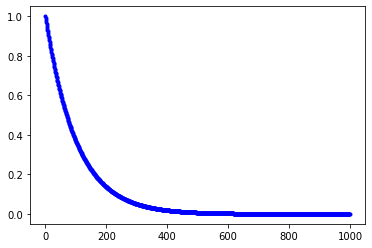

In [26]:
dicount: float = 0.01
X: np.array = 1 / (1 + dicount) ** np.arange(1000)
print(X[:15])
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot()
axes.plot(np.arange(X.shape[0]), X, '.', color='blue')
plt.show()

In [27]:
def get_novelty_matrix(recommendations: np.array, views: np.array, discount_rate: float = 0.01) -> np.array:
    """
    Apply novelty to recommendations.
    """
    return recommendations / (1 + discount_rate) ** views

In [28]:
X: np.array = np.array([
    [3, 5, 8],
    [2, 2, 2],
    [1, 0, 5],
])
V: np.array = np.array([
    [5, 0, 100],
    [0, 10, 20],
    [1, 0, 100],
])
Y:np.array = get_novelty_matrix(X, V)
print(Y)

[[2.85439706 5.         2.9576897 ]
 [2.         1.81057391 1.63908894]
 [0.99009901 0.         1.84855606]]


## Top K Recommendations Getter

In [29]:
def get_top_recommendations(recommendations: np.array, top: int = 3) -> np.array:
    """
    Top K recommendations getter.
    """
    X: np.array = np.copy(recommendations)
    X[np.isnan(X)] = 0
    return np.argsort(X)[:,::-1][:,:top]

In [30]:
X: np.array = np.array([
    [1, 2, 3, 4, 8, 3, 2, 2],
    [4, np.nan, 2, 1, 4, 3, 2, np.nan],
])
Y: np.array = get_top_recommendations(X, 3)
print(Y)

[[4 3 5]
 [4 0 5]]


## Recommendation Lists

In [31]:
def explain(top: np.array, adjacent: np.array, ratings: np.matrix, min_rating: float) -> np.array:
    """
    Explain Recommendations.
    """
    Z: np.array = np.empty(top.shape).astype(int)
    for user in range(top.shape[0]):
        for j in range(top.shape[1]):
            item = top[user][j]
            X: np.array = ratings[user][adjacent[item]]
            Y: np.array = np.greater(X, min_rating)
            if np.count_nonzero(~Y) == adjacent.shape[1]:
                Z[user][j] = -1
                continue
            Z[user][j] = adjacent[item][Y][np.nanargmax(X[Y])]
            print(f'Item #{top[user][j]} recommended to User #{user} because they liked Item #{Z[user][j]}.')
    return Z

In [32]:
top: np.array = np.array([
    [0, 1],
    [1, 2],
    [0, 1],
    [0, 2]
])
adjacent: np.array = np.array([
    [1, 2],
    [0, 2],
    [0, 1],
])
user_user: np.array = np.array([
    [np.nan, np.nan, 3],
    [4, 5, np.nan],
    [4, np.nan, 2],
    [0, 0, 1],
])
explained: np.array = explain(top, adjacent, user_user, 3)
print(explained)

Item #1 recommended to User #1 because they liked Item #0.
Item #2 recommended to User #1 because they liked Item #1.
Item #1 recommended to User #2 because they liked Item #0.
[[-1 -1]
 [ 0  1]
 [-1  0]
 [-1 -1]]


## Diversity

Diversity is a property of a recommendation list or a set of them composed by one or several recommender systems. It reflects how dissimilar items are to each other in the list. To measure diversity inside a list, researchers often calculate an average pairwise dissimilarity of items in a recommendation list.

## Serendipity

- https://link.springer.com/content/pdf/10.1007/s00607-018-0687-5.pdf

The dictionary definition of serendipity is “the faculty of making fortunate discoveries by accident”.

## Trending Items

In [33]:
def get_trending_items(recommendations: np.array, top: int = 5) -> np.array:
    """
    Trending Items getter.
    """
    trends: np.array = np.nansum(recommendations, axis=1) /\
        np.count_nonzero(~np.isnan(0.0001 + recommendations), axis=1)
    return trends[:top]

In [34]:
X: np.array = np.array([
    [np.nan, 1, 2, 3],
    [4, 0, 0, 2],
    [np.nan, 3, 3, 5],
])
Y: np.array = get_trending_items(X, 2)
print(Y)

[2.  1.5]


![user-user](./wallpaper.jpg)

## User-Based Collaborative Filtering

#### User-User Matrix

In [35]:
user_user: np.matrix = np.copy(ratings)
print(user_user.shape)
print(user_user)

(10, 15)
[[ 5.  3. nan nan  3. nan  1.  0.  0. nan  2.  5. nan  5.  1.]
 [ 2. nan  0.  5. nan nan nan  1.  5.  5.  5.  0.  5. nan  3.]
 [nan nan  0. nan  5.  0.  2. nan  5. nan  3. nan nan nan nan]
 [nan nan  1.  2. nan nan  1. nan  3.  4.  1.  5.  4. nan nan]
 [nan nan  5. nan nan nan  5. nan nan nan  1.  2. nan  4.  1.]
 [ 5. nan  3. nan nan  5.  5. nan nan nan nan nan  1.  1. nan]
 [ 5.  1. nan nan  3.  4. nan  0.  4. nan  0. nan nan  2. nan]
 [nan nan  4.  3. nan  1. nan  5. nan nan nan nan  0.  1. nan]
 [nan nan  5.  5.  5.  1.  5.  0.  5.  3. nan nan nan  1. nan]
 [nan  5.  0.  5.  5. nan nan nan nan  1.  5. nan nan  1.  5.]]


#### User-User Normalized Matrix

In [36]:
mean, deviation, normalized = get_normalized_matrix(user_user)
print(normalized.shape)
print(normalized)

(10, 15)
[[ 1.61711961  0.57027177         nan         nan  0.57027177         nan
  -0.47657608 -1.         -1.                 nan  0.04684785  1.61711961
          nan  1.61711961 -0.47657608]
 [-0.0343909          nan -1.          1.41402275         nan         nan
          nan -0.51719545  1.41402275  1.41402275  1.41402275 -1.
   1.41402275         nan  0.44841365]
 [        nan         nan -1.                 nan  1.42535625 -1.
  -0.0298575          nan  1.42535625         nan  0.45521375         nan
          nan         nan         nan]
 [        nan         nan -0.33100639  0.33798722         nan         nan
  -0.33100639         nan  1.00698082  1.67597443 -0.33100639  2.34496804
   1.67597443         nan         nan]
 [        nan         nan  1.88675135         nan         nan         nan
   1.88675135         nan         nan         nan -0.42264973  0.15470054
          nan  1.30940108 -0.42264973]
 [ 1.78543007         nan  0.67125804         nan         nan  1.7854300

#### User-User Similarity Matrix

In [37]:
similarity: np.array = get_similarity_matrix(normalized)
print(similarity.shape)
print(similarity)

(10, 10)
[[ 0.         -0.42540055 -0.22390409  0.57542526  0.29096367  0.22043746
   0.38389328 -0.47683708 -0.18166339  0.02199784]
 [-0.42540055  0.          0.90938593  0.34015255 -0.69520997 -0.40062782
   0.14489837 -0.45987898  0.52022829  0.67183898]
 [-0.22390409  0.90938593  0.          0.77937278 -0.71917007 -0.67916418
   0.21031513 -0.28355599  0.4314379   0.91184598]
 [ 0.57542526  0.34015255  0.77937278  0.         -0.11426102 -0.45649162
   0.62218336 -0.61942358  0.30036899 -0.13747318]
 [ 0.29096367 -0.69520997 -0.71917007 -0.11426102  0.          0.69674541
   0.27417255  0.38629411  0.7727195  -0.7037521 ]
 [ 0.22043746 -0.40062782 -0.67916418 -0.45649162  0.69674541  0.
   0.9582619   0.19675644  0.50861198 -0.32074218]
 [ 0.38389328  0.14489837  0.21031513  0.62218336  0.27417255  0.9582619
   0.         -0.79286002  0.6131241  -0.35869897]
 [-0.47683708 -0.45987898 -0.28355599 -0.61942358  0.38629411  0.19675644
  -0.79286002  0.          0.26137793 -0.03114659]


#### User-User Adjacency Matrix

In [38]:
adjacent: np.array = get_adjacency_matrix(similarity)
print(adjacent.shape)
print(adjacent)

(10, 4)
[[5 4 6 3]
 [3 8 9 2]
 [8 3 1 9]
 [1 0 6 2]
 [0 7 5 8]
 [0 8 4 6]
 [0 8 3 5]
 [7 5 8 4]
 [5 1 6 4]
 [0 8 1 2]]


#### Users Entropy Matrix

In [39]:
entropy: np.array = get_entropy_array(user_user.T)
print(entropy.shape)
print(entropy)

(10,)
[0.40546511 0.40546511 0.91629073 0.62860866 0.91629073 0.91629073
 0.62860866 0.91629073 0.51082562 0.62860866]


#### User-User Collaborative Filtering

In [40]:
predictions: np.array = get_predictions_matrix(ratings=user_user,
                                               normalized=normalized,
                                               mean=mean,
                                               deviation=deviation,
                                               similarity=similarity,
                                               entropy=entropy,
                                               adjacent=adjacent)
recommendations: np.array = get_recommendations_matrix(user_user, predictions)
print(recommendations)

[[5.90561193 1.65181263        nan        nan 3.77643251        nan
  4.21172155 0.58950268 4.58986922        nan 1.45927256 5.20451059
         nan 3.27150801 1.69252882]
 [2.                nan 1.99256453 5.50154582        nan        nan
         nan 1.02876848 5.94240138 3.7162594  4.3451719  7.95697171
  6.57133107        nan 5.91920571]
 [       nan        nan 1.53487126        nan 5.38554066 1.46922359
  2.98880284        nan 5.07028556        nan 4.14051095        nan
         nan        nan        nan]
 [       nan        nan 1.13021741 4.73865659        nan        nan
  2.41593252        nan 4.10145976 4.73865659 2.76666003 3.58885924
  4.73865659        nan        nan]
 [       nan        nan 4.81734912        nan        nan        nan
  5.52139388        nan        nan        nan 3.08114285 5.80093333
         nan 2.48660316 2.17454602]
 [6.49105384        nan 6.51934828        nan        nan 4.59811845
  6.15359005        nan        nan        nan        nan        nan
  1.

#### User-User Evaluation

In [41]:
nrmse: float = get_nrmse(user_user, predictions)
print('NRMSE', nrmse)

NRMSE 0.2826548778570869


#### User-User Novelty Recommendations

In [42]:
recommendations: np.matrix = get_novelty_matrix(recommendations, views)
print(recommendations)

[[5.84714052 1.63545805        nan        nan 3.77643251        nan
  4.21172155 0.58366602 4.49943066        nan 1.41635557 5.20451059
         nan 3.23911685 1.69252882]
 [2.                nan 1.99256453 5.44707507        nan        nan
         nan 0.99851255 5.88356572 3.7162594  4.3451719  7.87818981
  6.50626838        nan 5.91920571]
 [       nan        nan 1.51967452        nan 4.9242143  1.45467683
  2.95921073        nan 5.07028556        nan 4.09951579        nan
         nan        nan        nan]
 [       nan        nan 1.13021741 4.5992934         nan        nan
  2.3448803         nan 4.06085125 4.73865659 2.76666003 3.51814453
  4.6917392         nan        nan]
 [       nan        nan 4.76965259        nan        nan        nan
  5.52139388        nan        nan        nan 3.08114285 5.68663203
         nan 2.48660316 2.15301586]
 [6.42678598        nan 6.51934828        nan        nan 4.59811845
  6.09266341        nan        nan        nan        nan        nan
  1.

![user-user](./wallpaper.jpg)

## Item-Based Collaborative Filtering

#### Item-Item Matrix

In [43]:
item_item: np.array = np.copy(ratings.T)
print(item_item.shape)
print(item_item)

(15, 10)
[[ 5.  2. nan nan nan  5.  5. nan nan nan]
 [ 3. nan nan nan nan nan  1. nan nan  5.]
 [nan  0.  0.  1.  5.  3. nan  4.  5.  0.]
 [nan  5. nan  2. nan nan nan  3.  5.  5.]
 [ 3. nan  5. nan nan nan  3. nan  5.  5.]
 [nan nan  0. nan nan  5.  4.  1.  1. nan]
 [ 1. nan  2.  1.  5.  5. nan nan  5. nan]
 [ 0.  1. nan nan nan nan  0.  5.  0. nan]
 [ 0.  5.  5.  3. nan nan  4. nan  5. nan]
 [nan  5. nan  4. nan nan nan nan  3.  1.]
 [ 2.  5.  3.  1.  1. nan  0. nan nan  5.]
 [ 5.  0. nan  5.  2. nan nan nan nan nan]
 [nan  5. nan  4. nan  1. nan  0. nan nan]
 [ 5. nan nan nan  4.  1.  2.  1.  1.  1.]
 [ 1.  3. nan nan  1. nan nan nan nan  5.]]


#### Item-Item Normalized Matrix

In [44]:
mean, deviation, normalized = get_normalized_matrix(item_item)
print(normalized.shape)
print(normalized)

(15, 10)
[[ 2.84900179  0.53960072         nan         nan         nan  2.84900179
   2.84900179         nan         nan         nan]
 [ 0.83711731         nan         nan         nan         nan         nan
  -0.38762756         nan         nan  2.06186218]
 [        nan -1.         -1.         -0.52528734  1.37356332  0.42413799
          nan  0.89885065  1.37356332 -1.        ]
 [        nan  2.95284708         nan  0.58113883         nan         nan
          nan  1.37170825  2.95284708  2.95284708]
 [ 2.06186218         nan  4.10310363         nan         nan         nan
   2.06186218         nan  4.10310363  4.10310363]
 [        nan         nan -1.                 nan         nan  1.57855312
   1.06284249 -0.48428938 -0.48428938         nan]
 [-0.46334369         nan  0.07331263 -0.46334369  1.68328157  1.68328157
          nan         nan  1.68328157         nan]
 [-1.         -0.48428938         nan         nan         nan         nan
  -1.          1.57855312 -1.             

#### Item-Item Similarity Matrix

In [45]:
similarity: np.array = get_similarity_matrix(normalized)
print(similarity.shape)
print(similarity)

(15, 15)
[[ 0.          0.22969075  0.14155259  0.33333333  0.66666667  0.65431233
   0.32939358 -0.98069845  0.16634913  0.33333333 -0.20734415  0.45371541
  -0.10587692  0.54846055 -0.17715585]
 [ 0.22969075  0.         -0.33333333  0.33333333  0.82556145 -0.33333333
  -0.33333333 -0.22969075 -0.59917408 -0.33333333  0.89041525  0.33333333
   0.          0.19804923  0.55757678]
 [ 0.14155259 -0.33333333  0.         -0.07763902 -0.18345408  0.14525173
   0.81569214  0.14273446 -0.22784925 -0.24184872 -0.75631431  0.0695512
  -0.98702109  0.37645452 -0.77424484]
 [ 0.33333333  0.33333333 -0.07763902  0.          0.66666667 -0.62612933
   0.59649779 -0.26135324  0.99262044  0.62890056  0.94789554 -0.28440969
   0.51699613 -0.9558946   0.61310225]
 [ 0.66666667  0.82556145 -0.18345408  0.66666667  0.         -0.41175626
   0.58100903 -0.94359478  0.78124794  0.30802451  0.571724    0.33333333
   0.          0.15146484  0.52659399]
 [ 0.65431233 -0.33333333  0.14525173 -0.62612933 -0.4117

#### Item-Item Adjacency Matrix

In [46]:
adjacent: np.array = get_adjacency_matrix(similarity)
print(adjacent.shape)
print(adjacent)

(15, 4)
[[11 13  5  4]
 [11 14  4 10]
 [ 7  5 13  6]
 [ 9  4 10  8]
 [ 0  3  8  1]
 [13  2  6  0]
 [ 4  3  8  2]
 [ 7 14 10  2]
 [14  4  9  3]
 [10  3 12  8]
 [ 4  1 14  3]
 [ 1  4  0 13]
 [ 3 13  8  9]
 [ 2 11  0 12]
 [ 1  3  8 10]]


#### Items Entropy Matrix

In [47]:
entropy: np.array = get_entropy_array(item_item.T)
print(entropy.shape)
print(entropy)

(15,)
[0.91629073 1.2039728  0.22314355 0.69314718 0.69314718 0.69314718
 0.51082562 0.69314718 0.51082562 0.91629073 0.35667494 0.91629073
 0.91629073 0.35667494 0.91629073]


#### Item-Item Collaborative Filtering

In [48]:
predictions: np.array = get_predictions_matrix(ratings=item_item,
                                               normalized=normalized,
                                               mean=mean,
                                               deviation=deviation,
                                               similarity=similarity,
                                               entropy=entropy,
                                               adjacent=adjacent)
recommendations: np.array = get_recommendations_matrix(item_item, predictions)
print(recommendations)

[[ 6.61174475  2.95096189         nan         nan         nan  5.54345301
   5.99332196         nan         nan         nan]
 [ 4.35818506         nan         nan         nan         nan         nan
   4.58244795         nan         nan  7.57306038]
 [        nan  1.22982629  1.96443685  1.27394918  5.74164488  4.87680519
          nan  2.62646573  3.66997868  1.50091999]
 [        nan  6.54289853         nan  5.0395725          nan         nan
          nan  3.          6.77793597  6.1042043 ]
 [ 5.26263374         nan  5.94935706         nan         nan         nan
   5.10223577         nan  6.56312204  6.49725744]
 [        nan         nan  2.04749116         nan         nan  6.85372912
   7.53836489  2.92450051  5.02099415         nan]
 [ 4.4298898          nan  7.36015243  3.9051515   5.72615079  3.95700115
          nan         nan  8.37203796         nan]
 [ 1.14105361  0.66395985         nan         nan         nan         nan
  -0.73907194  2.94293608  3.86343809         nan]


#### Item-Item Evaluation

In [49]:
nrmse: float = get_nrmse(item_item, predictions)
print('NRMSE', nrmse)

NRMSE 0.22452677023798312


#### Item-Item Novelty Recommendations

In [50]:
recommendations: np.array = get_novelty_matrix(recommendations, views.T)
print(recommendations)

[[ 6.54628193  2.95096189         nan         nan         nan  5.48856734
   5.99332196         nan         nan         nan]
 [ 4.31503471         nan         nan         nan         nan         nan
   4.53707718         nan         nan  7.42384117]
 [        nan  1.22982629  1.94498698  1.27394918  5.68479691  4.87680519
          nan  2.60046112  3.66997868  1.48605939]
 [        nan  6.47811736         nan  4.89135942         nan         nan
          nan  3.          6.77793597  5.98392736]
 [ 5.26263374         nan  5.43973409         nan         nan         nan
   5.10223577         nan  6.56312204  6.49725744]
 [        nan         nan  2.02721897         nan         nan  6.85372912
   7.53836489  2.75501178  4.97128133         nan]
 [ 4.4298898          nan  7.28727963  3.79030157  5.72615079  3.91782292
          nan         nan  8.20707574         nan]
 [ 1.12975605  0.64443289         nan         nan         nan         nan
  -0.73907194  2.9137981   3.86343809         nan]


#### Item-Item Top K Recommendations

In [51]:
top: np.array = get_top_recommendations(recommendations.T)
print(top)

[[11  0 13]
 [ 8 12  3]
 [ 8 10  6]
 [ 8 11  3]
 [11  6  2]
 [ 5  0  2]
 [ 5  8 13]
 [12  3  7]
 [ 6  8  3]
 [ 1  9 10]]


#### Trending Items

In [52]:
trending: np.array = get_trending_items(recommendations, 3)
print(trending)

[5.24478328 5.42531769 2.84585797]


#### Item-Item Recommendation Explanation

In [53]:
explained: np.array = explain(top, adjacent, user_user, 4)
print(explained)

Item #11 recommended to User #0 because they liked Item #0.
Item #0 recommended to User #0 because they liked Item #11.
Item #13 recommended to User #0 because they liked Item #11.
Item #8 recommended to User #1 because they liked Item #9.
Item #12 recommended to User #1 because they liked Item #3.
Item #3 recommended to User #1 because they liked Item #9.
Item #8 recommended to User #2 because they liked Item #4.
Item #10 recommended to User #2 because they liked Item #4.
Item #6 recommended to User #2 because they liked Item #4.
Item #6 recommended to User #4 because they liked Item #2.
Item #2 recommended to User #4 because they liked Item #6.
Item #5 recommended to User #5 because they liked Item #6.
Item #0 recommended to User #5 because they liked Item #5.
Item #2 recommended to User #5 because they liked Item #5.
Item #5 recommended to User #6 because they liked Item #0.
Item #13 recommended to User #6 because they liked Item #0.
Item #7 recommended to User #7 because they liked

![user-user](./wallpaper.jpg)

## Dimensionality Reduction

In [57]:
ratings: np.array = get_random_ratings_matrix(users=1000, items=500)
ratings = get_hot_users(ratings, min_ratings=20)
views: np.array = get_random_views_matrix(ratings)
item_item = ratings.T
user_user  = ratings
mean, deviation, normalized = get_normalized_matrix(item_item)
similarity: np.array = get_similarity_matrix(normalized, min_shared_ratings=50)
adjacent: np.array = get_adjacency_matrix(similarity)
entropy: np.array = get_entropy_array(item_item.T)
predictions: np.array = get_predictions_matrix(ratings=item_item,
                                               normalized=normalized,
                                               mean=mean,
                                               deviation=deviation,
                                               similarity=similarity,
                                               entropy=entropy,
                                               adjacent=adjacent)
nrmse: float = get_nrmse(item_item, predictions)
print('NRMSE', nrmse)
recommendations: np.array = get_recommendations_matrix(item_item, predictions)
recommendations: np.array = get_novelty_matrix(recommendations, views.T)
top: np.array = get_top_recommendations(recommendations.T, top=3)
trending: np.array = get_trending_items(recommendations, top=5)
explained: np.array = explain(top, adjacent, user_user, min_rating=4)

NRMSE 0.35772404177839184
Item #267 recommended to User #0 because they liked Item #142.
Item #414 recommended to User #0 because they liked Item #122.
Item #394 recommended to User #0 because they liked Item #122.
Item #218 recommended to User #1 because they liked Item #424.
Item #104 recommended to User #1 because they liked Item #364.
Item #88 recommended to User #1 because they liked Item #489.
Item #137 recommended to User #2 because they liked Item #424.
Item #495 recommended to User #2 because they liked Item #182.
Item #457 recommended to User #2 because they liked Item #492.
Item #394 recommended to User #3 because they liked Item #90.
Item #381 recommended to User #3 because they liked Item #63.
Item #275 recommended to User #3 because they liked Item #425.
Item #314 recommended to User #4 because they liked Item #412.
Item #187 recommended to User #4 because they liked Item #484.
Item #261 recommended to User #4 because they liked Item #51.
Item #366 recommended to User #5 

Item #304 recommended to User #556 because they liked Item #226.
Item #88 recommended to User #556 because they liked Item #489.
Item #420 recommended to User #556 because they liked Item #148.
Item #287 recommended to User #557 because they liked Item #87.
Item #268 recommended to User #557 because they liked Item #272.
Item #29 recommended to User #557 because they liked Item #484.
Item #261 recommended to User #558 because they liked Item #190.
Item #143 recommended to User #558 because they liked Item #484.
Item #197 recommended to User #558 because they liked Item #470.
Item #437 recommended to User #559 because they liked Item #173.
Item #348 recommended to User #559 because they liked Item #27.
Item #304 recommended to User #559 because they liked Item #489.
Item #282 recommended to User #560 because they liked Item #232.
Item #4 recommended to User #560 because they liked Item #492.
Item #53 recommended to User #560 because they liked Item #221.
Item #153 recommended to User #5